In [3]:
import numpy as np
import gym
from util import log_progress, histogram
import matplotlib.pyplot as plt
import numpy as np

In [4]:
env = gym.make('CartPole-v1')
observation = env.reset()

[2019-11-22 13:24:36,933] Making new env: CartPole-v1


In [5]:
def plot_episode_lengths(episode_lengths, epsilons):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.subplot(211)
    plt.plot(episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    
    plt.subplot(212)
    plt.plot(epsilons)
    plt.show(fig1)

In [6]:
from keras.models import Sequential
from keras.layers import Dense # Dropout, BatchNormalization
from keras.optimizers import Adam

class Approximator:
    """A function approximator implemented with a deep neural net."""
    def __init__(self, num_inputs, num_outputs, learning_rate=0.01):
        self.model = Sequential()
        self.model.add(Dense(64, input_shape=(num_inputs,), activation='relu'))
        #self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(num_outputs, activation='linear'))

        adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        self.model.compile(optimizer=adam, loss='mse', metrics=['accuracy','mse'])

    def predict_multi(self, X_batch):
        """Predict the outputs for multiple input values at once.
        X_batch: an np array of m number of X values to predict, of shape (num_inputs, m)
        where m is the number of items you'd like to predict.
        """
        return self.model.predict(X_batch)
    
    def train_multi(self, X, Y, batch_size=16, epochs=1, verbose=0):
        """
        Train the model with m samples.
        X: the input values, of shape (num_inputs, m)
        Y: the target values, of shape (num_outputs, m)
        """
        return self.model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    def predict(self, X):
        """Predict a single output given a single input.
        X: one set of X values to predict. X shape is (num_inputs,).
        """
        predictions = self.predict_multi(np.array([X])) # An array for m input values.
        return predictions[0] # We have a batch size of one here; return the first.
    
    def train(self, X, Y):
        """Train a single input/output pair.
        X: inputs of shape (num_inputs,)
        Y: target outputs of shape (num_outputs,)"""
        batch_X = np.array([X])
        batch_Y = np.array([Y])
        self.train_multi(batch_X, batch_Y, batch_size=1)

In [7]:
ap = Approximator(num_inputs=4, num_outputs=2)
X = np.array([[1,2,3,4], [1,1,1,1]])
ap.predict_multi(X)

array([[ 0.07639673,  0.55625844],
       [-0.14834023,  0.16520333]], dtype=float32)

Now train the output for 1234 to be closer to -4,5:

In [8]:
ap.train(np.array([1,2,3,4]), np.array([-4, 5]))

In [9]:
ap.predict(np.array([1,2,3,4]))

array([-0.65417737,  1.82559061], dtype=float32)

In [33]:
class Agent:
    def __init__(self, env, policy):
        self.env = env
        self.policy = policy
    
    def run_episode(self, render=False):
        episode = [] # prev_state, prev_action, reward, state, done
        state = env.reset()
        action = None
        while True:
            prev_state = state
            prev_action = action
            action = self.policy.suggest_action(state)
            state, reward, done, _ = env.step(action)
            episode.append((prev_state, prev_action, reward, state, done))
            self.policy.step_completed(prev_state, prev_action, reward, state, done)
            if render:
                self.env.render()
            if done:
                break
        return episode
    
    def train(self, episodes=100, render=False, epsilon_start=1.0, epsilon_min = 0.01, epsilon_decay=0.995):
        episode_lengths = []
        epsilons = []
        
        epsilon_orig = agent.policy.epsilon # Save the original epsilon, in case we want to do external things with agent later.
        agent.policy.epsilon = epsilon_start
        
        for i in log_progress(range(episodes), name='Episodes'):
            episode = self.run_episode(render=render)
            episode_lengths.append(len(episode))
            epsilons.append(agent.policy.epsilon)
            agent.policy.episode_completed(episode)
            
        plot_episode_lengths(episode_lengths, epsilons)
        print('Max length=%f avg=%f' % (np.max(episode_lengths), np.mean(episode_lengths)))
        
        agent.policy.epsilon = epsilon_orig # Restore epsilon.

In [74]:
from collections import deque
import random

class QLearningPolicy:            
    def __init__(self, env, learning_rate=0.001, epsilon_start=1, epsilon_min=0.01, epsilon_decay=0.995,
                 gamma=0.95, snapshots=1000000, batch_size=20):
        """epsilon: probability of exploring by selecting a random action
        gamma: Discount factor for future rewards. Between 0 - 1.
        learning_rate: learning rate for the approximator
        """
        self.env = env
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma # Discount factor for future rewards.
        self.snapshots = deque(maxlen=snapshots) # [(prev_state, prev_action, reward, next_state, done)]
        num_inputs = self.env.observation_space.shape[0] # 4
        num_outputs = self.env.action_space.n # 2
        self.model = Approximator(num_inputs, num_outputs, learning_rate)
        self.batch_size = batch_size

    def suggest_action(self, state, epsilon=None):
        if epsilon == None:
            epsilon = self.epsilon
        if np.random.uniform() <= epsilon:
            return self.env.action_space.sample()

        rewards_all = self.model.predict(state) # Rewards for all possible actions
        action = np.argmax(rewards_all) # Index of the action having the highest rewards.
        return action

    def step_completed(self, prev_state, prev_action, reward, state, done):
        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        
        # Save this activity for experience replay.
        self.snapshots.append((prev_state, prev_action, reward, state, done))
        
        if len(self.snapshots) >= self.batch_size:
            # Replay a batch of experiences.  This shuffles them so we don't train on a bunch of similar
            # states all at once (temporal separation).
            steps = random.sample(self.snapshots, self.batch_size)
            for (prev_state, prev_action, reward, state, done) in steps:
                rewards_all = self.model.predict(prev_state)
                if done:
                    future_rewards = 0
                else:
                    future_rewards = np.max(self.model.predict(state))
                target_reward = reward + self.gamma * future_rewards
                rewards_all[prev_action] = target_reward
                self.model.train(prev_state, rewards_all)
    
    def episode_completed(self, episode):
        pass


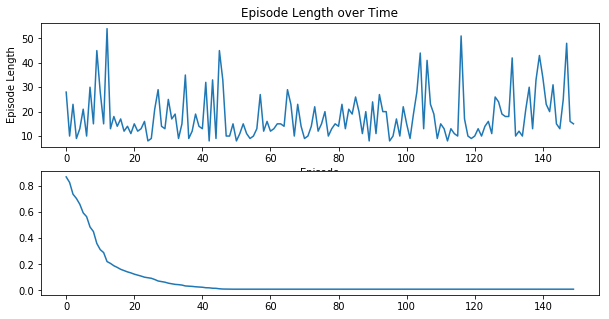

Max length=54.000000 avg=18.173333


In [75]:
agent = Agent(env, QLearningPolicy(env))
agent.train(episodes=150)

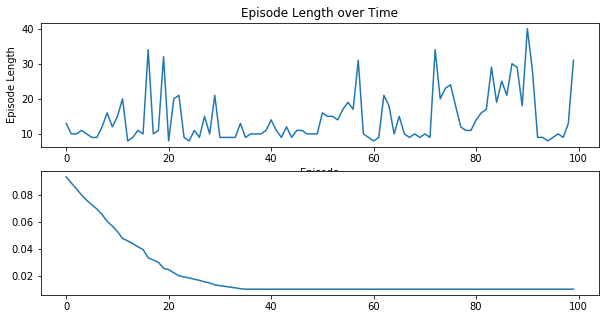

Max length=40.000000 avg=14.480000


In [73]:
agent.train(episodes=100, epsilon_start=0.1)

In [69]:
def peek():
    state = env.reset()
    return agent.policy.model.predict(state)
peek()

array([ 157.91218567,  171.70553589], dtype=float32)